# CSV Generation - fine_tunning

In [1]:
import os.path
import sys
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from imageio import imsave
from torch.utils import model_zoo
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
from building_footprint_segmentation.seg.binary.models import ReFineNet
from building_footprint_segmentation.helpers.normalizer import min_max_image_net
from building_footprint_segmentation.utils.py_network import ( to_input_image_tensor, add_extra_dimension,
    convert_tensor_to_numpy, load_parallel_model, adjust_model,)
from building_footprint_segmentation.utils.operations import handle_image_size


In [2]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
MAX_SIZE = 224
TRAINED_MODEL = ReFineNet().to(device)

pretrained_model_path = "out_data/20230727-144442/state/best.pt"

c:\Users\pc\anaconda3\envs\SW\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\pc\anaconda3\envs\SW\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
# best pt
pretrained_dict = torch.load(pretrained_model_path)["model"]


def remove_module_from_keys(dictionary):
    new_dict = {}  # 새로운 딕셔너리를 생성하여 수정된 키값을 저장할 준비

    for key, value in dictionary.items():
        new_key = key.replace("module.", "")  # "module_"을 ""로 치환하여 새로운 키값 생성
        new_dict[new_key] = value  # 새로운 키값과 기존 value를 새로운 딕셔너리에 저장

    return new_dict

pretrained_dict = remove_module_from_keys(pretrained_dict)

TRAINED_MODEL.load_state_dict(pretrained_dict)

<All keys matched successfully>

In [5]:
def set_model_weights(pretrained_model_path):
    #MODEL_URL = "https://github.com/fuzailpalnak/building-footprint-segmentation/releases/download/alpha/refine.zip"
    #state_dict = model_zoo.load_url(MODEL_URL, progress=True, map_location="cpu")
    #if "model" in state_dict:
    #    state_dict = state_dict["model"]
    #TRAINED_MODEL.load_state_dict(adjust_model(state_dict))
    # 사전 학습된 모델의 상태 딕셔너리를 불러오기
    pretrained_dict = torch.load(pretrained_model_path)
    TRAINED_MODEL.load_state_dict(pretrained_dict)


In [6]:
def extract(original_image):
    original_height, original_width = original_image.shape[:2]

    if (original_height, original_width) != (MAX_SIZE, MAX_SIZE):
        original_image = handle_image_size(original_image, (MAX_SIZE, MAX_SIZE))

    # Apply Normalization
    normalized_image = min_max_image_net(img=original_image)

    tensor_image = add_extra_dimension(to_input_image_tensor(normalized_image))

    with torch.no_grad():
        # Perform prediction
        #original_image = torch.from_numpy(original_image)
        tensor_image = tensor_image.to(device)

        prediction = TRAINED_MODEL(tensor_image)
        prediction = prediction.sigmoid()

    prediction_binary = convert_tensor_to_numpy(prediction[0]).reshape(
        (MAX_SIZE, MAX_SIZE)
    )

    """prediction_3_channels = cv2.cvtColor(prediction_binary, cv2.COLOR_GRAY2RGB)

    dst = cv2.addWeighted(
        original_image,
        1,
        (prediction_3_channels * (0, 255, 0)).astype(np.uint8),
        0.4,
        0,
    )"""
    return prediction_binary#, prediction_3_channels, dst

In [7]:
def run(image_path, pretrained_model_path):
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    
    #set_model_weights(pretrained_model_path) # best.pt시 주석
    # PARALLELIZE the model if gpu available
    # model = load_parallel_model(model)

    prediction_binary = extract(original_image) #, prediction_3_channels, dst
    # imsave(f"{os.path.basename(image_path)}", prediction_binary)
    return prediction_binary#, prediction_3_channels, dst

In [8]:
# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [9]:
import os
from natsort import natsorted
file_names = natsorted(os.listdir('../../test_img'))

In [10]:
aaa = run('../../test_img/TEST_00002.png', pretrained_model_path);aaa

array([[0.00237114, 0.00210773, 0.00187353, ..., 0.00031439, 0.00041212,
        0.00054021],
       [0.00210264, 0.00193745, 0.00178522, ..., 0.00028323, 0.00035603,
        0.00044753],
       [0.00186448, 0.0017809 , 0.00170106, ..., 0.00025516, 0.00030757,
        0.00037074],
       ...,
       [0.00033004, 0.00028886, 0.00025282, ..., 0.00416166, 0.00404389,
        0.00392944],
       [0.00034754, 0.00029698, 0.00025378, ..., 0.00383919, 0.0039361 ,
        0.00403546],
       [0.00036596, 0.00030533, 0.00025474, ..., 0.00354161, 0.00383118,
        0.00414432]], dtype=float32)

In [11]:
aaa_1 = (aaa > 0.85).astype(np.uint8)

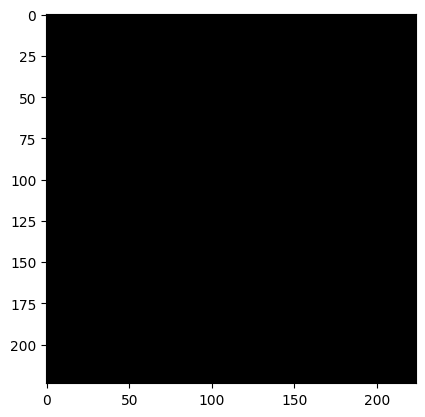

In [12]:
import matplotlib.pyplot as plt
plt.imshow(aaa_1, cmap=plt.cm.binary_r)
plt.show()

In [13]:
from tqdm import tqdm
import pandas as pd

result_35 = []

for file_name in tqdm(file_names):
    PRED_PTH = f'../../test_img/{file_name}'
    pred = run(PRED_PTH, pretrained_model_path)
    masks_1 = (pred > 0.4).astype(np.uint8)
    mask_rle_1 = rle_encode(masks_1)
    if mask_rle_1 == '': # 예측된 건물 픽셀이 아예 없는 경우 -1
        result_35.append(-1)
    else:
        result_35.append(mask_rle_1)

100%|██████████| 60640/60640 [28:23<00:00, 35.60it/s]


In [14]:
submit = pd.read_csv('./sample_submission.csv')
submit['mask_rle'] = result_35

In [15]:
submit.to_csv('../../Sub/Data_patch_original_merge_moon_code.csv', index=False)

### Classfication 결과 + Segmentation 결과

In [1]:
import pandas as pd
df = pd.read_csv('../../Sub/Data_patch_original_merge_moon_code.csv')
df

,img_id,mask_rle
0,TEST_00000,20913 16 21131 25 21352 29 21574 32 21797 34 2...
1,TEST_00001,44298 3 44519 10 44742 12 44964 15 45187 17 45...
2,TEST_00002,-1
3,TEST_00003,20 20 243 22 467 23 691 24 915 24 1139 24 1363...
4,TEST_00004,16227 1 16447 12 16670 15 16893 19 17116 22 17...
...,...,...
60635,TEST_60635,-1
60636,TEST_60636,29095 3 29317 8 29538 12 29760 15 29975 25 301...
60637,TEST_60637,57 17 281 18 505 18 729 19 953 19 1176 20 1400...
60638,TEST_60638,-1


In [2]:
suk = pd.read_csv('0suk.csv');suk

,img_id,mask_rle
0,TEST_00000,0
1,TEST_00001,0
2,TEST_00002,-1
3,TEST_00003,0
4,TEST_00004,0
...,...,...
60635,TEST_60635,0
60636,TEST_60636,0
60637,TEST_60637,0
60638,TEST_60638,-1


In [3]:
suk.mask_rle = suk.mask_rle.astype('str')

In [4]:
df.iloc[:, :].query('mask_rle=="-1"')

,img_id,mask_rle
2,TEST_00002,-1
7,TEST_00007,-1
8,TEST_00008,-1
12,TEST_00012,-1
15,TEST_00015,-1
...,...,...
60625,TEST_60625,-1
60627,TEST_60627,-1
60628,TEST_60628,-1
60635,TEST_60635,-1


In [5]:
suk.iloc[:, :].query('mask_rle=="-1"')

,img_id,mask_rle
2,TEST_00002,-1
7,TEST_00007,-1
8,TEST_00008,-1
11,TEST_00011,-1
15,TEST_00015,-1
...,...,...
60626,TEST_60626,-1
60628,TEST_60628,-1
60630,TEST_60630,-1
60632,TEST_60632,-1


In [6]:
suk_50000 = suk.iloc[:, :].query('mask_rle=="-1"');suk_50000

,img_id,mask_rle
2,TEST_00002,-1
7,TEST_00007,-1
8,TEST_00008,-1
11,TEST_00011,-1
15,TEST_00015,-1
...,...,...
60626,TEST_60626,-1
60628,TEST_60628,-1
60630,TEST_60630,-1
60632,TEST_60632,-1


In [7]:
suk_50000 = suk_50000.rename(columns = {'mask_rle' : 'mask_rle_1'});suk_50000

,img_id,mask_rle_1
2,TEST_00002,-1
7,TEST_00007,-1
8,TEST_00008,-1
11,TEST_00011,-1
15,TEST_00015,-1
...,...,...
60626,TEST_60626,-1
60628,TEST_60628,-1
60630,TEST_60630,-1
60632,TEST_60632,-1


In [8]:
df

,img_id,mask_rle
0,TEST_00000,20913 16 21131 25 21352 29 21574 32 21797 34 2...
1,TEST_00001,44298 3 44519 10 44742 12 44964 15 45187 17 45...
2,TEST_00002,-1
3,TEST_00003,20 20 243 22 467 23 691 24 915 24 1139 24 1363...
4,TEST_00004,16227 1 16447 12 16670 15 16893 19 17116 22 17...
...,...,...
60635,TEST_60635,-1
60636,TEST_60636,29095 3 29317 8 29538 12 29760 15 29975 25 301...
60637,TEST_60637,57 17 281 18 505 18 729 19 953 19 1176 20 1400...
60638,TEST_60638,-1


In [9]:
suk_50000

,img_id,mask_rle_1
2,TEST_00002,-1
7,TEST_00007,-1
8,TEST_00008,-1
11,TEST_00011,-1
15,TEST_00015,-1
...,...,...
60626,TEST_60626,-1
60628,TEST_60628,-1
60630,TEST_60630,-1
60632,TEST_60632,-1


In [10]:
new = pd.merge(df, suk_50000,how='outer');new

,img_id,mask_rle,mask_rle_1
0,TEST_00000,20913 16 21131 25 21352 29 21574 32 21797 34 2...,NaN
1,TEST_00001,44298 3 44519 10 44742 12 44964 15 45187 17 45...,NaN
2,TEST_00002,-1,-1
3,TEST_00003,20 20 243 22 467 23 691 24 915 24 1139 24 1363...,NaN
4,TEST_00004,16227 1 16447 12 16670 15 16893 19 17116 22 17...,NaN
...,...,...,...
60635,TEST_60635,-1,NaN
60636,TEST_60636,29095 3 29317 8 29538 12 29760 15 29975 25 301...,NaN
60637,TEST_60637,57 17 281 18 505 18 729 19 953 19 1176 20 1400...,NaN
60638,TEST_60638,-1,-1


In [11]:
def custom_column(row):
    if pd.notna(row['mask_rle_1']):
        return row['mask_rle_1']
    else:
        return row['mask_rle']

In [12]:
new['mask_rle_2'] = new.apply(custom_column, axis=1)

In [13]:
sub = new.drop(columns=['mask_rle', 'mask_rle_1'])

In [14]:
sub = sub.rename(columns = {'mask_rle_2' : 'mask_rle'})

In [15]:
sub

,img_id,mask_rle
0,TEST_00000,20913 16 21131 25 21352 29 21574 32 21797 34 2...
1,TEST_00001,44298 3 44519 10 44742 12 44964 15 45187 17 45...
2,TEST_00002,-1
3,TEST_00003,20 20 243 22 467 23 691 24 915 24 1139 24 1363...
4,TEST_00004,16227 1 16447 12 16670 15 16893 19 17116 22 17...
...,...,...
60635,TEST_60635,-1
60636,TEST_60636,29095 3 29317 8 29538 12 29760 15 29975 25 301...
60637,TEST_60637,57 17 281 18 505 18 729 19 953 19 1176 20 1400...
60638,TEST_60638,-1


In [79]:
sub.to_csv('../../Sub/LastDance_Gwang.csv', index=False)

In [80]:
pd.read_csv('./submission/to_the_moon_2.csv')

,img_id,mask_rle
0,TEST_00000,19779 6 20002 10 20033 6 20226 10 20256 7 2045...
1,TEST_00001,36284 5 36507 6 36730 7 36953 8 37176 9 37399 ...
2,TEST_00002,-1
3,TEST_00003,19 24 75 7 242 25 301 3 465 27 689 27 913 28 1...
4,TEST_00004,16893 16 17115 22 17338 44 17562 44 17786 45 1...
...,...,...
60635,TEST_60635,-1
60636,TEST_60636,29316 11 29538 12 29752 1 29758 15 29974 21 30...
60637,TEST_60637,57 14 89 15 281 15 313 15 505 15 537 15 729 15...
60638,TEST_60638,-1
